# TGFBR1

The TGFBR1 gene encodes a serine/threonine kinase receptor for transforming growth factor-beta (TGFB1; [OMIM:190180](https://omim.org/entry/190181)). Pathogenic variants in TGFBR1 are associated with  two Mendelian diseases, [Loeys-Dietz syndrome 1; OMIM:609192](https://omim.org/entry/609192) and [Multiple self-healing squamous epithelioma, susceptibility to (MSSE); OMIM:132800](https://omim.org/entry/132800) (see below under *Explorative analysis*). This notebook
shows how to perform statistical testing of an hypothesis that was proposed (without formal testing) in a publication which first described
TGFBR1 variants in MSSE.

In [1]:
import gpsea
from gpsea.analysis.predicate import PatientCategories
from gpsea.preprocessing import load_phenopacket_folder
from gpsea.preprocessing import configure_caching_cohort_creator
from gpsea.model import FeatureType, VariantEffect
from gpsea.view import CohortViewable
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer, ProteinViewable
import hpotk
import gpsea

from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.1.dev0


## TGFBR1

TGFBR1 codes for todo

In [2]:
gene_symbol = 'TGFBR1'
mane_tx_id = 'NM_004612.4'
mane_protein_id = 'NP_004603.1' # TGF-beta receptor type-1 isoform 1 precursor [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.19'  # Update, if necessary
registry = configure_phenopacket_registry()

#with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
#    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

## TODO -- UPDATE TO USE phenopacket store after next release
from pyphetools.visualization import PhenopacketIngestor
pp_dir = '/Users/robin/GIT/phenopacket-store/notebooks/TGFBR1/phenopackets'
ingestor = PhenopacketIngestor(indir=pp_dir)
phenopackets = ingestor.get_phenopacket_list()


print(f'Loaded {len(phenopackets)} phenopackets')

[pyphetools] Ingested 41 GA4GH phenopackets.
Loaded 41 phenopackets


In [4]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')

Individuals Processed: 100%|██████████| 41/41 [00:56<00:00,  1.37s/individuals]
Loaded 41 individuals


In [5]:
qc.summarize()

Validated under none policy
No errors or warnings were found


# Explorative analysis

We were not able to identify publications that present a statistical analysis of correlations of specific TGFBR1 variants or variant classes with specific phenotypic manifestations. However, pathogenic variants in TGFBR1 are associated with two clinically very different diseases, 
[Loeys-Dietz syndrome 1; OMIM:609192](https://omim.org/entry/609192) and [Multiple self-healing squamous epithelioma, susceptibility to (MSSE); OMIM:132800](https://omim.org/entry/132800). The authors of the first publication about MSSE state:

> The nature of the sequence variants, which include mutations in the extracellular ligand-binding domain and a series of truncating mutations in the kinase domain, indicates a clear genotype-phenotype correlation between loss-of-function TGFBR1 mutations and MSSE ([Goudie et al., 2011](https://pubmed.ncbi.nlm.nih.gov/21358634/)).

Therefore, we will create genotype predicates that encode the corresponding group of variants.

In [6]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
report = cv.process(cohort, transcript_id=mane_tx_id)
display(HTML(report))

HPO Term,ID,Seen in n individuals
Self-healing squamous epithelioma,HP:0034720,18
Scoliosis,HP:0002650,18
Hypertelorism,HP:0000316,15
Malar flattening,HP:0000272,14
High palate,HP:0000218,12
Joint hypermobility,HP:0001382,12
Dolichocephaly,HP:0000268,12
Aortic root aneurysm,HP:0002616,11
Pes planus,HP:0001763,11
Dermal translucency,HP:0010648,11


In [7]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_87329/1613228306.py:4: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


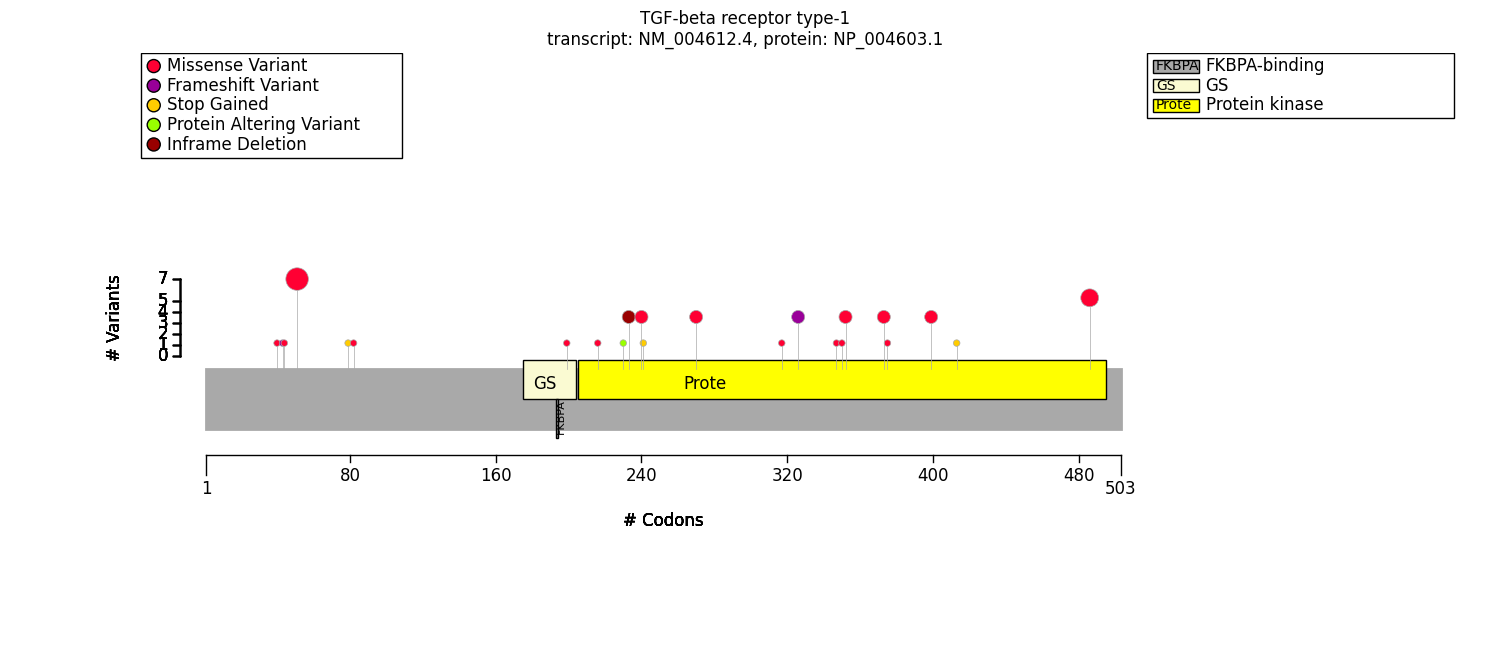

In [8]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

## Examining a proposed GPC

In [Goudie et al., 2011](https://pubmed.ncbi.nlm.nih.gov/21358634/), the authors note that all variants found in individuals with MSSE were either missense variants in exon 2 of TGFBR1, encoding part of the extracellular (ligand binding) domain, or were nonsense, splice, or frameshift variants in exons 4, 6 and 7 of the region that encodes the kinase domain. We will therefore create a category of variants that comprises either Exon 2 or presumed loss of function variants (nonsense, splice, or frameshift). There does not seem to be a reason to limit the loss of function variants to exons 4,6, and 7 (because, for example, one of the exon 2 variants is presumed loss of function).


In [13]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, ModeOfInheritancePredicate

exon_2_pred = VariantPredicates.exon(2, mane_tx_id)
frameshift_pred = VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, mane_tx_id)
splice_acc_pred = VariantPredicates.variant_effect(VariantEffect.SPLICE_ACCEPTOR_VARIANT, mane_tx_id)
splice_donor_pred = VariantPredicates.variant_effect(VariantEffect.SPLICE_DONOR_VARIANT, mane_tx_id)
nonsense_pred = VariantPredicates.variant_effect(VariantEffect.STOP_GAINED, mane_tx_id)

msse_variant_pred = exon_2_pred | frameshift_pred | splice_acc_pred | splice_donor_pred | nonsense_pred

	


gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(msse_variant_pred)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_87329/1859946942.py:17: DeprecationWarning: Use `gpsea.analysis.predicate.genotype.autosomal_dominant` instead
  gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(msse_variant_pred)


In [14]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [15]:
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

In [16]:
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [17]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

In [18]:
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
report = viewer.process(result)
display(HTML(report))

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,13
HMF04,Skipping term because all genotypes have same HPO observed proportions,23
HMF05,Skipping term because one genotype had zero observations,47
HMF06,Skipping term with less than 7 observations (not powered for 2x2),69
HMF08,Skipping general term,58


In [19]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

What is the genotype group                     HOM_REF            HET          \
                                                 Count Percent  Count Percent   
Self-healing squamous epithelioma [HP:0034720]    0/21      0%  18/19     95%   
Hypertelorism [HP:0000316]                       15/19     79%   0/18      0%   
Arterial tortuosity [HP:0005116]                  8/16     50%   1/19      5%   
Bifid uvula [HP:0000193]                          4/16     25%   0/18      0%   
Pectus excavatum [HP:0000767]                     2/13     15%    1/1    100%   
Pulmonary artery aneurysm [HP:0004937]             5/7     71%    0/1      0%   
High palate [HP:0000218]                         11/15     73%    1/1    100%   
Scoliosis [HP:0002650]                           17/20     85%    1/1    100%   
Striae distensae [HP:0001065]                     6/13     46%    1/1    100%   
Mitral valve prolapse [HP:0001634]                8/20     40%    0/1      0%   
Mitral regurgitation [HP:0001653]                 9/21     43%    0/1      0%   
Retrognathia [HP:0000278]                          5/9     56%    0/1      0%   
Cleft palate [HP:0000175]                         4/20     20%    0/1      0%   
Pectus carinatum [HP:0000768]                     7/17     41%    0/1      0%   

What is the genotype group                                         \
                                               Corrected p values   
Self-healing squamous epithelioma [HP:0034720]       2.346087e-09   
Hypertelorism [HP:0000316]                           3.507401e-06   
Arterial tortuosity [HP:0005116]                     2.302340e-02   
Bifid uvula [HP:0000193]                             1.373555e-01   
Pectus excavatum [HP:0000767]                        6.000000e-01   
Pulmonary artery aneurysm [HP:0004937]               8.750000e-01   
High palate [HP:0000218]                             1.000000e+00   
Scoliosis [HP:0002650]                               1.000000e+00   
Striae distensae [HP:0001065]                        1.000000e+00   
Mitral valve prolapse [HP:0001634]                   1.000000e+00   
Mitral regurgitation [HP:0001653]                    1.000000e+00   
Retrognathia [HP:0000278]                            1.000000e+00   
Cleft palate [HP:0000175]                            1.000000e+00   
Pectus carinatum [HP:0000768]                        1.000000e+00   

What is the genotype group                                    
                                                    p values  
Self-healing squamous epithelioma [HP:0034720]  1.675777e-10  
Hypertelorism [HP:0000316]                      5.010572e-07  
Arterial tortuosity [HP:0005116]                4.933586e-03  
Bifid uvula [HP:0000193]                        3.924444e-02  
Pectus excavatum [HP:0000767]                   2.142857e-01  
Pulmonary artery aneurysm [HP:0004937]          3.750000e-01  
High palate [HP:0000218]                        1.000000e+00  
Scoliosis [HP:0002650]                          1.000000e+00  
Striae distensae [HP:0001065]                   1.000000e+00  
Mitral valve prolapse [HP:0001634]              1.000000e+00  
Mitral regurgitation [HP:0001653]               1.000000e+00  
Retrognathia [HP:0000278]                       1.000000e+00  
Cleft palate [HP:0000175]                       1.000000e+00  
Pectus carinatum [HP:0000768]                   1.000000e+00